# Prior-Posterior Derived-Predictive Consistency Checks for

Post-Estimation Calculated Quantities of Interest (*QOI-Check*)

Case Study I: Marginal expectation log-link linear mixed model

Holger Sennhenn-Reulen [](https://orcid.org/0000-0002-4782-4387) (Northwest German Forest Research Institute (NW-FVA))  
December 17, 2024

# Intro

Relevant parts of the code given here is inspired by the resources of the great *SBC* package \[@ModrakEtAl2023\] published at <https://hyunjimoon.github.io/SBC/index.html>.

Also, coding of posterior p-values is inspired by the split predictive check \[@LiHuggins2024\] R code published at <https://github.com/TARPS-group/split-predictive-checks>.

## Software

We use the statistical software environment *R* \[@RCoreTeam2024\], and R add-on packages <!-- *ggplot2* [@Wickham2016]. --> <!-- and *plyr* [@Wickham2011].  --> *colorspace* \[@StaufferEtAl2009\], <!-- **cowplot** [@Wilke2023] --> *SBC* \[@ModrakEtAl2023\], *brms* \[@Buerkner2017;@Buerkner2018;@Buerkner2021\], *cmdstanr* \[@GabryEtAl2024\], *ggplot2* \[@Wickham2016\], and *future* \[@Bengtsson2021\].

This document is produced using *Quarto* \[@AllaireEtAl2024\].

# Organize R Session

In [ ]:
# setwd("~/Dropbox/forschung/simulation_based_calibration/application_D_post_estimation_calculation")
setwd("~/Dropbox/forschung/reference_grid_posterior_predictive_check/application_A_log_link_multilevel_model")
library("SBC")
library("brms")

Lade nötiges Paket: Rcpp

Loading 'brms' package (version 2.21.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attache Paket: 'brms'

Das folgende Objekt ist maskiert 'package:stats':

    ar

This is cmdstanr version 0.8.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/hsennhenn/.cmdstan/cmdstan-2.35.0

- CmdStan version: 2.35.0


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable cmdstanr_no_ver_check=TRUE.

Load packages:

In [ ]:
library("SBC")
library("brms")
library("cmdstanr")
library("ggplot2")
library("colorspace")
library("cowplot")
library("future")

Settings:

In [ ]:
rm(list = ls())
options(brms.backend = "cmdstanr")
# Using parallel processing
plan(multisession)
options(SBC.min_chunk_size = 5)
# Setup caching of results
cache_dir <- "./_SBC_cache"
if(!dir.exists(cache_dir)) {
  dir.create(cache_dir)
}

In [ ]:
rm(list = ls())
library("SBC")
library("brms")
library("cmdstanr")
library("ggplot2")
library("colorspace")
library("cowplot")
library("future")
options(brms.backend = "cmdstanr")
# Using parallel processing
plan(multisession)
options(SBC.min_chunk_size = 5)
# Setup caching of results
cache_dir <- "./_SBC_cache"
if(!dir.exists(cache_dir)) {
  dir.create(cache_dir)
}

Data preparation function for graphical uniformity checks:

In [ ]:
## from https://github.com/TeemuSailynoja/simultaneous-confidence-bands/tree/main
dat_ecdf_diff <- function (x, variables = NULL, K = NULL, 
                           gamma = NULL, prob = 0.95, 
                           combine_variables = NULL, 
                           ecdf_alpha = NULL, ..., 
                           parameters = NULL) {
  if (!is.null(parameters)) {
    warning("The `parameters` argument is deprecated use `variables` instead.")
    if (is.null(variables)) {
      variables <- parameters
    }
  }
  ecdf_data <- data_for_ecdf_plots(x, variables = variables,
                                   prob = prob, K = K, gamma = gamma, combine_variables = combine_variables,
                                   ecdf_alpha = ecdf_alpha, ...)
  if (ecdf_data$N < 50 && is.null(K)) {
    message("With less than 50 simulations, we recommend using plot_ecdf as it has better fidelity.\n",
            "Disable this message by explicitly setting the K parameter. ",
            "You can use the strings \"max\" (high fidelity) or \"min\" (nicer plot) or choose a specific integer.")
  }
  N <- ecdf_data$N
  K <- ecdf_data$K
  z <- ecdf_data$z
  ecdf_df <- dplyr::mutate(ecdf_data$ecdf_df, z_diff = ecdf -
                             z, type = "sample ECDF")
  limits_df_trans <- dplyr::mutate(ecdf_data$limits_df, ymax = upper -
                                     uniform_val, ymin = lower - uniform_val, type = "theoretical CDF")
  return(list('ecdf_df' = ecdf_df,
              'limits_df_trans' = limits_df_trans))
}

# Data Generator

The data can be generated using the following code – note that we need to be careful to match the parameter names as `brms` uses them.

In [ ]:
f_generate_y <- function(sim_df, 
                         b_Intercept, 
                         b_x, 
                         grouping_term, ## sd_g__Intercept or r_g
                         sigma) {
  if (is.matrix(grouping_term)) {
    r_g <- grouping_term
  } else {
    G <- length(levels(sim_df$g))
    r_g <- matrix(rnorm(n = G, mean = 0, sd = grouping_term), 
                  nrow = G, ncol = 1,
                  dimnames = list(levels(sim_df$g), "Intercept"))
  }
  sim_df$'mu' <- exp(b_Intercept + 
                       sim_df$'x' * b_x + 
                       r_g[sim_df$'g'])
  sim_df$'sigma' <- sigma
  sim_df$'y' <- rnorm(n = nrow(sim_df), 
                      mean = sim_df$'mu', 
                      sd = sim_df$'sigma')
  return(sim_df)
}
f_generate_one_sim <- function(N, G) {
  prior_mu <- list('b_Intercept' = 0,
                   'b_x' = 1,
                   'sd_g__Intercept' = .5,
                   'sigma' = 1)
  prior_sd <- list('b_Intercept' = .1,
                   'b_x' = .1,
                   'sd_g__Intercept' = .1,
                   'sigma' = .1)
  b_Intercept <- rnorm(n = 1, 
                       mean = prior_mu$b_Intercept, 
                       sd = prior_sd$b_Intercept)
  b_x <- rnorm(n = 1, 
               mean = prior_mu$b_x, 
               sd = prior_sd$b_x)
  sd_g__Intercept <- rnorm(n = 1, 
                           mean = prior_mu$sd_g__Intercept, 
                           sd = prior_sd$sd_g__Intercept)
  sd_g__Intercept <- abs(sd_g__Intercept)
  sigma <- rnorm(n = 1, 
                 mean = prior_mu$sigma, 
                 sd = prior_sd$sigma)
  sigma <- abs(sigma)
  indx <- rep(c(5, 25, 45), c(6, 8, 6))
  if (sum(indx) != 500) {
    stop("'N' must be 500 currently!")
  }
  g <- paste0("Group ", formatC(1:G, width = 2, flag = "0"))
  g <- sample(g)
  g <- rep(g, indx)
  g <- as.factor(g)
  r_g <- matrix(rnorm(n = G, mean = 0, sd = sd_g__Intercept), 
                nrow = G, ncol = 1,
                dimnames = list(levels(g), "Intercept"))
  sim_df_skeleton <- data.frame('x' = 2 * runif(N), 
                                'g' = g)
  return(list('variables' = list('b_Intercept' = b_Intercept,
                                 'b_x' = b_x,
                                 'sd_g__Intercept' = sd_g__Intercept, 
                                 'r_g' = r_g,
                                 'sigma' = sigma),
              'generated' = f_generate_y(sim_df = sim_df_skeleton, 
                                         b_Intercept, 
                                         b_x, 
                                         grouping_term = r_g, 
                                         sigma)))
}
f_generate_n_sims <- SBC_generator_function(f_generate_one_sim, 
                                            N = 500, 
                                            G = 20)
set.seed(0)
datasets <- generate_datasets(f_generate_n_sims, 100)
head(datasets$generated[[1]])

          x        g       mu    sigma        y
1 0.6933670 Group 11 2.010588 1.127243 1.257388
2 0.6675499 Group 11 1.960995 1.127243 3.026448
3 0.9527025 Group 11 2.583906 1.127243 3.072794
4 1.7843967 Group 11 5.776880 1.127243 6.909938
5 1.7286789 Group 11 5.473749 1.127243 5.033990
6 0.7799791 Group 14 3.143628 1.127243 3.567889

## Descriptive Plot

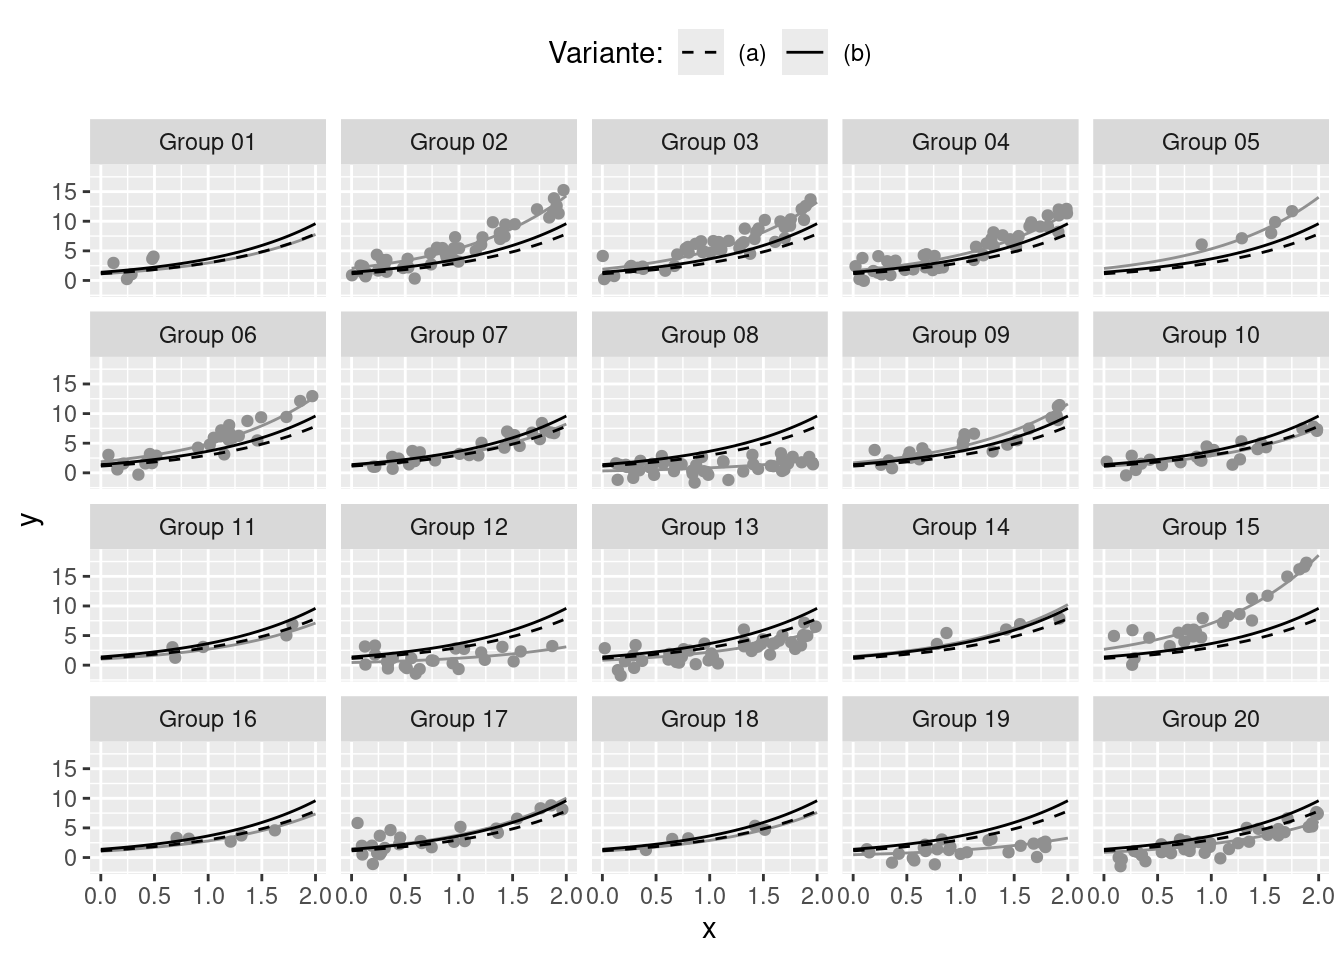

In [ ]:
r <- 1
dat <- as.data.frame(expand.grid(x = seq(0, 2, by = .05), g = 1:20))
b <- as.numeric(datasets$variables[r, ])
dat$y <- exp(b[1] + dat$x * b[2] + b[dat$g + 3])
dat$g <- paste0("Group ", formatC(dat$g, width = 2, flag = "0"))
dat$k <- dat$l <- "Single group"
dat <- rbind(dat, 
             data.frame(x = seq(0, 2, by = .05), 
                        y = exp(b[1] + dat$x * b[2]), 
                        g = "Group 21",
                        k = "(a)",
                        l = "Average"),
             data.frame(x = seq(0, 2, by = .05), 
                        y = exp(b[1] + dat$x * b[2] + .5 * b[3]^2), 
                        g = "Group 22",
                        k = "(b)",
                        l = "Average"))
sdat <- subset(dat, l == "Average")
sdat$g <- NULL
paint <- colorspace::sequential_hcl(n = 20, pal = "Grays")[10]
ggplot(data = datasets$generated[[r]], aes(x = x, y = y)) +
  geom_line(data = subset(dat, l != "Average"), color = paint) +
  geom_point(, color = paint) + 
  geom_line(data = sdat, aes(group = k, linetype = k), color = 1) +
  scale_linetype_manual(values = c(2, 1)) +
  facet_wrap(~ g) +
  labs(linetype = "Variante:") +
  theme(legend.position = "top")

In [ ]:
pdf("20241217_data_marginal_expectation_log_link_linear_mixed_model.pdf", 
    height = 6, width = 8)
ggplot(data = datasets$generated[[r]], aes(x = x, y = y)) +
  geom_line(data = subset(dat, l != "Average"), color = paint) +
  geom_point(, color = paint) + 
  geom_line(data = sdat, aes(group = k, linetype = k), color = 1) +
  scale_linetype_manual(values = c(2, 1)) +
  facet_wrap(~ g) +
  labs(linetype = "Variante:") +
  theme(legend.position = "top")
invisible(dev.off())
tables_g <- sapply(datasets$generated, FUN = function(x){table(x[, 'g'])})
df_tables_g <- reshape2::melt(tables_g)
sdf <- subset(df_tables_g, Var2 < 30.5)
sdf$Var1 <- factor(as.character(sdf$Var1),
                   levels = rev(levels(sdf$Var1)))
pdf("20241217_data_groups_marginal_expectation_log_link_linear_mixed_model.pdf",
    height = 6, width = 8)
ggplot(sdf, aes(x = Var2, y = Var1)) +
  geom_tile(aes(fill = value), width = .9, height = .9) +
  labs(x = "Simulation run", y = "g",
       fill = "Frequency:") +
  theme(legend.position = 'none') +
  colorspace::scale_fill_continuous_sequential(pal = "Grays",
                                               limits = c(0, 100)) +
  geom_text(aes(label = value), size = 3)
invisible(dev.off())

# Backend

In [ ]:
priors <- 
  prior(normal(0,.1), class = "b", coef = "Intercept") +
  prior(normal(1,.1), class = "b", coef = "x") +
  prior(normal(.5,.1), class = "sd") +
  prior(normal(1,.1), class = "sigma")
stan_file_filename <- "brms_log_link_linear_mixed_model.stan"
f_backend <- SBC_backend_brms(bf(y ~ 0 + Intercept + x + (1 | g)),
                              family = gaussian(link = "log"),
                              prior = priors, 
                              chains = 1,
                              template_data = datasets$generated[[1]],
                              out_stan_file = file.path(cache_dir, 
                                                        stan_file_filename))

log_lik_log_link_lmm <- derived_quantities(
  log_lik = sum(dnorm(y, 
                      mean = exp(b_Intercept + x * b_x + r_g[g]),
                      sd = sigma,
                      log = TRUE)))
results <- compute_SBC(datasets, 
                       f_backend, 
                       dquants = log_lik_log_link_lmm, 
                       cache_mode = "results", 
                       cache_location = file.path(cache_dir, 
                                              "results_log_link_linear_mixed_model"))

In [ ]:
results <- readRDS(file = "./_202401021_SBC_cache/results_log_link_linear_mixed_model.rds")

In [ ]:
tmp <- results$result$stats[, c("sim_id", "variable", "rank")]
tmp <- dat_ecdf_diff(tmp, 
                     variables = c("b_Intercept", "b_x", "sd_g__Intercept", "sigma", 
                                   "log_lik"), 
                     max_rank = 99)
tmp$variable <- factor(tmp$variable, 
                       levels = c("b_Intercept", "b_x", "sd_g__Intercept", "sigma", 
                                  "log_lik"))
col_color <- c(colorspace::sequential_hcl(n = 20, pal = "Grays")[10], "black")
col_fill <- c(colorspace::sequential_hcl(n = 20, pal = "Grays")[10], "black")
names(col_color) <- names(col_fill) <- 
    c("theoretical CDF", "sample ECDF")
l <- c('theoretical CDF' = expression("Theoretical CDF"), 
       'sample ECDF' = expression("Sample ECDF"))

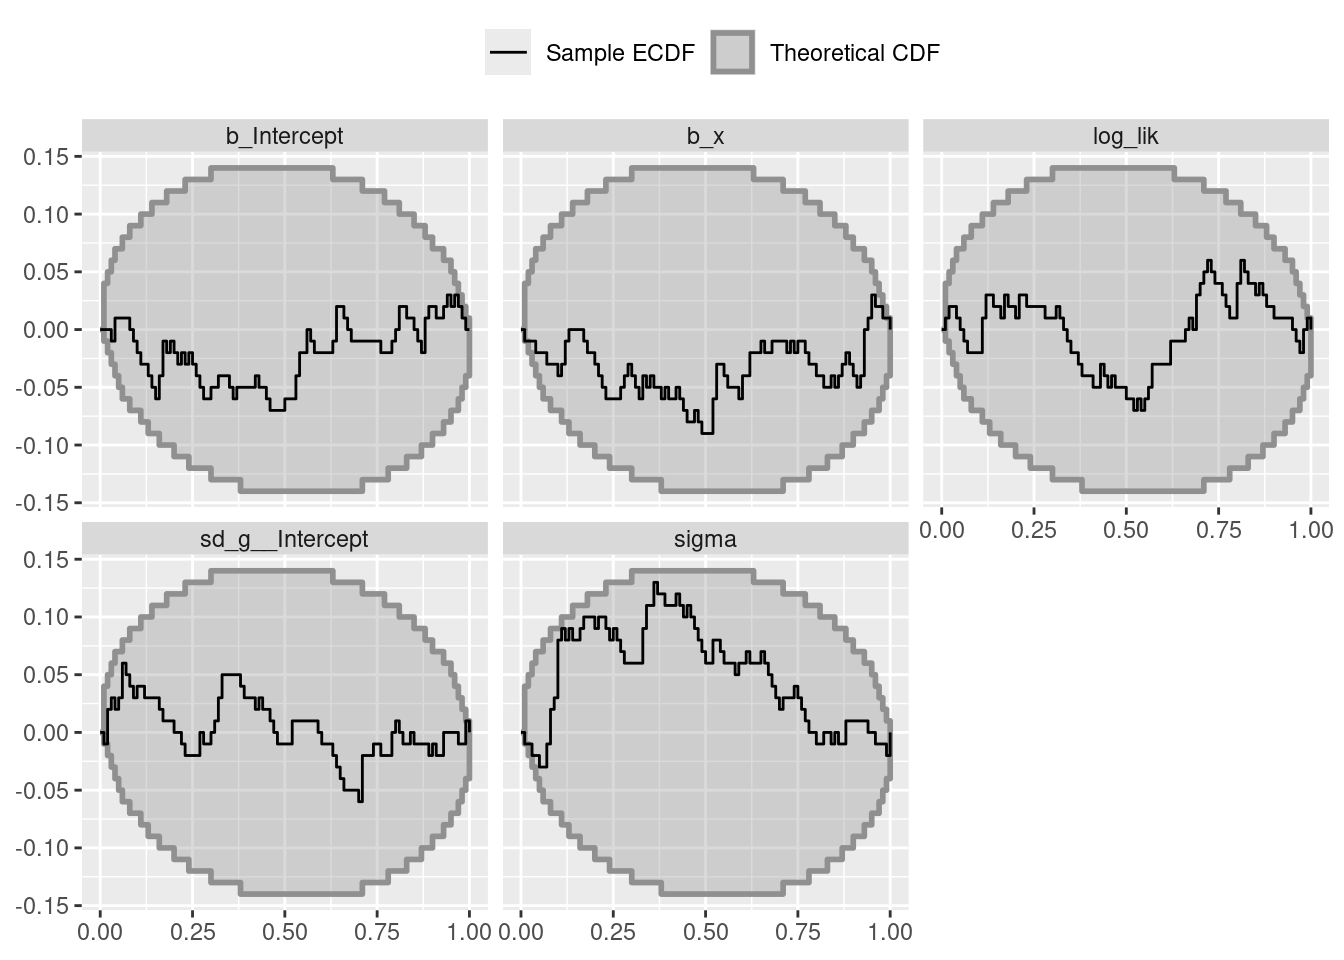

In [ ]:
ggplot(tmp$ecdf_df, aes(color = type, fill = type)) + 
  geom_ribbon(data = tmp$limits_df_trans, 
              aes(x = x, ymax = ymax, ymin = ymin), alpha = .33, 
              linewidth = 1) + 
  geom_step(aes(x = z, y = z_diff, group = variable)) + 
  scale_color_manual(name = "", values = col_color, labels = l) + 
  scale_fill_manual(name = "", values = col_fill, labels = l) + 
  scale_alpha_identity() + 
  xlab(NULL) + 
  ylab(NULL) + 
  facet_wrap(~ variable) +
  theme(strip.text = element_text(margin = margin(b = 2, t = 2))) +
  theme(legend.position = "top")

In [ ]:
pdf("20241217_case_study_I_SBC.pdf", height = 6, width = 8)
ggplot(tmp$ecdf_df, aes(color = type, fill = type)) + 
  geom_ribbon(data = tmp$limits_df_trans, 
              aes(x = x, ymax = ymax, ymin = ymin), alpha = .33, 
              linewidth = 1) + 
  geom_step(aes(x = z, y = z_diff, group = variable)) + 
  scale_color_manual(name = "", values = col_color, labels = l) + 
  scale_fill_manual(name = "", values = col_fill, labels = l) + 
  scale_alpha_identity() + 
  xlab(NULL) + 
  ylab(NULL) + 
  facet_wrap(~ variable) +
  theme(strip.text = element_text(margin = margin(b = 2, t = 2))) +
  theme(legend.position = "top")
invisible(dev.off())

In [ ]:
# plot_ecdf_diff_green(results, 
#                      variables = c('log_lik', 'b_Intercept', 'b_x', 
#                                    'sd_g__Intercept', 'sigma'), K = 20) + 
#   theme(legend.position = "top")
# dev.off()

# Calculate QOI-Check

Preparations:

In [ ]:
f_predict_brms_gaussian <- function(fit, nd) {
  predict(fit, newdata = nd,
          summary = F, 
          allow_new_levels = T, 
          sample_new_levels = "gaussian")
}
f_predict_brms_uncrtnty <- function(fit, nd) {
  predict(fit, newdata = nd,
          summary = F, 
          allow_new_levels = T, 
          sample_new_levels = "uncertainty")
}
set.seed(123456789)
p_stat_mean_ref_gr_gaussian_a <- p_stat_mean_ref_gr_uncrtnty_a <- 
  p_stat_mean_ref_gr_gaussian_b <- p_stat_mean_ref_gr_uncrtnty_b <- 
  p_stat_mean_sim_df_gaussian_a <- p_stat_mean_sim_df_uncrtnty_a <- 
  p_stat_mean_sim_df_gaussian_b <- p_stat_mean_sim_df_uncrtnty_b <- 
  ## [October 22, 2024]
  p_stat_mean_ref_gr_gaussian_c <- p_stat_mean_ref_gr_uncrtnty_c <- 
  p_stat_mean_ref_gr_gaussian_d <- p_stat_mean_ref_gr_uncrtnty_d <- 
  p_stat_mean_sim_df_gaussian_c <- p_stat_mean_sim_df_uncrtnty_c <- 
  p_stat_mean_sim_df_gaussian_d <- p_stat_mean_sim_df_uncrtnty_d <- 
  ##  
  p_stat_mean_ref_gr_gaussian_e <- p_stat_mean_ref_gr_uncrtnty_e <- 
  p_stat_mean_ref_gr_gaussian_f <- p_stat_mean_ref_gr_uncrtnty_f <- 
  p_stat_mean_sim_df_gaussian_e <- p_stat_mean_sim_df_uncrtnty_e <- 
  p_stat_mean_sim_df_gaussian_f <- p_stat_mean_sim_df_uncrtnty_f <- 
  ## 
  p_stat_mean_eq_a_a <- p_stat_mean_eq_a_b <- p_stat_mean_eq_a_c <- 
  p_stat_mean_eq_a_d <- p_stat_mean_eq_a_e <- p_stat_mean_eq_a_f <- 
  ## 
  p_stat_mean_eq_b_a <- p_stat_mean_eq_b_b <- p_stat_mean_eq_b_c <- 
  p_stat_mean_eq_b_d <- p_stat_mean_eq_b_e <- p_stat_mean_eq_b_f <- 
  ## 
  rep(NA, length(results$fits))

Loop through the simulation runs and calculate all QOI variants for each run:

In [ ]:
for (r in 1:length(results$fits)) {
  ## Prior in repetition r:
  prior_r <- subset(results$stats, sim_id == r)
  ## Methods a and b:
  equation_a <- exp(subset(prior_r, variable == "b_Intercept")$simulated_value + 
                      1 * subset(prior_r, variable == "b_x")$simulated_value)
  equation_b <- exp(subset(prior_r, variable == "b_Intercept")$simulated_value +    
                      1 * subset(prior_r, variable == "b_x")$simulated_value + 
                      .5 * (subset(prior_r, 
                                   variable == "sd_g__Intercept")$simulated_value^2))
  ## Reference grid data 'ref_gr':
  g <- paste0("g", formatC(101:300, width = 3, flag = "0"))
  ref_gr <- data.frame('x' = 1, 
                       'g' = as.factor(g))
  ## Duplicate observation data 'sim_df':
  sim_df <- results$fits[[r]]$data[, c('x', 'g')]
  sim_df$x <- 1 ## November 15, 2024
  g <- 100 + as.numeric(sim_df$g) ## 'break' original levels
  g <- paste0("g", formatC(g, width = 3, flag = "0"))
  sim_df$g <- as.factor(g)
  ## Prior predictions (methods c and d):
  y_prior_pred <- f_generate_y(sim_df = ref_gr, 
                               b_Intercept = subset(prior_r, 
                                          variable == "b_Intercept")$simulated_value, 
                               b_x = subset(prior_r, 
                                            variable == "b_x")$simulated_value, 
                               grouping_term = subset(prior_r, 
                                      variable == "sd_g__Intercept")$simulated_value,
                               sigma = subset(prior_r, 
                                                variable == "sigma")$simulated_value)
  ref_gr$y_prior_pred <- y_prior_pred$y
  rm(y_prior_pred)
  y_prior_pred <- f_generate_y(sim_df = sim_df, 
                               b_Intercept = subset(prior_r, 
                                          variable == "b_Intercept")$simulated_value, 
                               b_x = subset(prior_r, 
                                                  variable == "b_x")$simulated_value, 
                               grouping_term = subset(prior_r, 
                                      variable == "sd_g__Intercept")$simulated_value, 
                               sigma = subset(prior_r, 
                                                variable == "sigma")$simulated_value)
  sim_df$y_prior_pred <- y_prior_pred$y
  rm(y_prior_pred)
  reference_c <- mean(ref_gr$y_prior_pred)
  reference_d <- mean(sim_df$y_prior_pred)
  b <- datasets$variables[r, ]
  b <- as.numeric(b)
  ## Prior 'uncertainty' for ref_gr: 
  gamma <- sample(b[grep(x = colnames(datasets$variables), 
                         pattern = "r_g[Group", fixed = T)], 
                  size = 200, replace = T)
  gamma <- matrix(gamma, nrow = 200, ncol = 1,
                  dimnames = list(levels(ref_gr$g), "Intercept"))
  ref_gr$y_prior_pred_uncrtnty <- f_generate_y(sim_df = ref_gr,
                                               b_Intercept = 
                             b[which(colnames(datasets$variables) == "b_Intercept")],
                                               b_x = 
                                     b[which(colnames(datasets$variables) == "b_x")],
                                               grouping_term = gamma,
                                               sigma = 
                                 b[which(colnames(datasets$variables) == "sigma")])$y
  ## Prior 'uncertainty' for sim_df:
  gamma <- sample(b[grep(x = colnames(datasets$variables), 
                         pattern = "r_g[Group", fixed = T)], 
                  size = 20, replace = T)
  gamma <- matrix(gamma, nrow = 20, ncol = 1,
                  dimnames = list(levels(sim_df$g), "Intercept"))
  sim_df$y_prior_pred_uncrtnty <- f_generate_y(sim_df = sim_df,
                                               b_Intercept = 
                             b[which(colnames(datasets$variables) == "b_Intercept")],
                                               b_x = 
                                     b[which(colnames(datasets$variables) == "b_x")],
                                               grouping_term = gamma,
                                               sigma = 
                                 b[which(colnames(datasets$variables) == "sigma")])$y
  reference_e <- mean(ref_gr$y_prior_pred_uncrtnty)
  reference_f <- mean(sim_df$y_prior_pred_uncrtnty)
  B <- as.matrix(results$fits[[r]]) ## Posterior sample
  posterior_equation_a <- exp(B[, "b_Intercept"] + 1 * B[, "b_x"])
  posterior_equation_b <- exp(B[, "b_Intercept"] + 1 * B[, "b_x"] + 
                                .5 * B[, "sd_g__Intercept"]^2)
  Y_rep_ref_gr_g <- f_predict_brms_gaussian(results$fits[[r]], ref_gr)
  Y_rep_ref_gr_u <- f_predict_brms_uncrtnty(results$fits[[r]], ref_gr)
  Y_rep_sim_df_g <- f_predict_brms_gaussian(results$fits[[r]], sim_df)
  Y_rep_sim_df_u <- f_predict_brms_uncrtnty(results$fits[[r]], sim_df)
  stat_mean_ref_gr_uncrtnty_a <- stat_mean_ref_gr_gaussian_a <- 
    stat_mean_ref_gr_uncrtnty_b <- stat_mean_ref_gr_gaussian_b <- 
    stat_mean_sim_df_uncrtnty_a <- stat_mean_sim_df_gaussian_a <- 
    stat_mean_sim_df_uncrtnty_b <- stat_mean_sim_df_gaussian_b <- 
    ## 
    stat_mean_ref_gr_uncrtnty_c <- stat_mean_ref_gr_gaussian_c <- 
    stat_mean_ref_gr_uncrtnty_d <- stat_mean_ref_gr_gaussian_d <- 
    stat_mean_sim_df_uncrtnty_c <- stat_mean_sim_df_gaussian_c <- 
    stat_mean_sim_df_uncrtnty_d <- stat_mean_sim_df_gaussian_d <- 
    ## 
    stat_mean_ref_gr_uncrtnty_e <- stat_mean_ref_gr_gaussian_e <- 
    stat_mean_ref_gr_uncrtnty_f <- stat_mean_ref_gr_gaussian_f <- 
    stat_mean_sim_df_uncrtnty_e <- stat_mean_sim_df_gaussian_e <- 
    stat_mean_sim_df_uncrtnty_f <- stat_mean_sim_df_gaussian_f <- 
    ## 
    eq_a_a <- eq_a_b <- eq_a_c <- eq_a_d <- eq_a_e <- eq_a_f <- 
    eq_b_a <- eq_b_b <- eq_b_c <- eq_b_d <- eq_b_e <- eq_b_f <- 
    rep(NA, nrow(Y_rep_ref_gr_g))
  for (s in 1:nrow(Y_rep_ref_gr_g)) {
    ref_gr$y_rep_gaussian <- Y_rep_ref_gr_g[s, ]
    ref_gr$y_rep_uncrtnty <- Y_rep_ref_gr_u[s, ]
    sim_df$y_rep_gaussian <- Y_rep_sim_df_g[s, ]
    sim_df$y_rep_uncrtnty <- Y_rep_sim_df_u[s, ]
    ## Calculate stats:
    stat_mean_ref_gr_gaussian_a[s] <- equation_a < mean(ref_gr$y_rep_gaussian)
    stat_mean_ref_gr_uncrtnty_a[s] <- equation_a < mean(ref_gr$y_rep_uncrtnty)
    stat_mean_ref_gr_gaussian_b[s] <- equation_b < mean(ref_gr$y_rep_gaussian)
    stat_mean_ref_gr_uncrtnty_b[s] <- equation_b < mean(ref_gr$y_rep_uncrtnty)
    stat_mean_sim_df_gaussian_a[s] <- equation_a < mean(sim_df$y_rep_gaussian)
    stat_mean_sim_df_uncrtnty_a[s] <- equation_a < mean(sim_df$y_rep_uncrtnty)
    stat_mean_sim_df_gaussian_b[s] <- equation_b < mean(sim_df$y_rep_gaussian)
    stat_mean_sim_df_uncrtnty_b[s] <- equation_b < mean(sim_df$y_rep_uncrtnty)
    ## 
    stat_mean_ref_gr_gaussian_c[s] <- reference_c < mean(ref_gr$y_rep_gaussian)
    stat_mean_ref_gr_uncrtnty_c[s] <- reference_c < mean(ref_gr$y_rep_uncrtnty)
    stat_mean_ref_gr_gaussian_d[s] <- reference_d < mean(ref_gr$y_rep_gaussian)
    stat_mean_ref_gr_uncrtnty_d[s] <- reference_d < mean(ref_gr$y_rep_uncrtnty)
    stat_mean_sim_df_gaussian_c[s] <- reference_c < mean(sim_df$y_rep_gaussian)
    stat_mean_sim_df_uncrtnty_c[s] <- reference_c < mean(sim_df$y_rep_uncrtnty)
    stat_mean_sim_df_gaussian_d[s] <- reference_d < mean(sim_df$y_rep_gaussian)
    stat_mean_sim_df_uncrtnty_d[s] <- reference_d < mean(sim_df$y_rep_uncrtnty)
    ## 
    stat_mean_ref_gr_gaussian_e[s] <- reference_e < mean(ref_gr$y_rep_gaussian)
    stat_mean_ref_gr_uncrtnty_e[s] <- reference_e < mean(ref_gr$y_rep_uncrtnty)
    stat_mean_ref_gr_gaussian_f[s] <- reference_f < mean(ref_gr$y_rep_gaussian)
    stat_mean_ref_gr_uncrtnty_f[s] <- reference_f < mean(ref_gr$y_rep_uncrtnty)
    stat_mean_sim_df_gaussian_e[s] <- reference_e < mean(sim_df$y_rep_gaussian)
    stat_mean_sim_df_uncrtnty_e[s] <- reference_e < mean(sim_df$y_rep_uncrtnty)
    stat_mean_sim_df_gaussian_f[s] <- reference_f < mean(sim_df$y_rep_gaussian)
    stat_mean_sim_df_uncrtnty_f[s] <- reference_f < mean(sim_df$y_rep_uncrtnty)
    ## 
    eq_a_a[s] <- equation_a < posterior_equation_a[s]
    eq_a_b[s] <- equation_b < posterior_equation_a[s]
    eq_a_c[s] <- reference_c < posterior_equation_a[s]
    eq_a_d[s] <- reference_d < posterior_equation_a[s]
    eq_a_e[s] <- reference_e < posterior_equation_a[s]
    eq_a_f[s] <- reference_f < posterior_equation_a[s]
    ## 
    eq_b_a[s] <- equation_a < posterior_equation_b[s]
    eq_b_b[s] <- equation_b < posterior_equation_b[s]
    eq_b_c[s] <- reference_c < posterior_equation_b[s]
    eq_b_d[s] <- reference_d < posterior_equation_b[s]
    eq_b_e[s] <- reference_e < posterior_equation_b[s]
    eq_b_f[s] <- reference_f < posterior_equation_b[s]
  }
  ## Calculate posterior predictive p-values:
  p_stat_mean_ref_gr_gaussian_a[r] <- mean(stat_mean_ref_gr_gaussian_a)
  p_stat_mean_ref_gr_gaussian_b[r] <- mean(stat_mean_ref_gr_gaussian_b)
  p_stat_mean_ref_gr_gaussian_c[r] <- mean(stat_mean_ref_gr_gaussian_c)
  p_stat_mean_ref_gr_gaussian_d[r] <- mean(stat_mean_ref_gr_gaussian_d)
  p_stat_mean_ref_gr_gaussian_e[r] <- mean(stat_mean_ref_gr_gaussian_e)
  p_stat_mean_ref_gr_gaussian_f[r] <- mean(stat_mean_ref_gr_gaussian_f)
  ##
  p_stat_mean_ref_gr_uncrtnty_a[r] <- mean(stat_mean_ref_gr_uncrtnty_a)
  p_stat_mean_ref_gr_uncrtnty_b[r] <- mean(stat_mean_ref_gr_uncrtnty_b)
  p_stat_mean_ref_gr_uncrtnty_c[r] <- mean(stat_mean_ref_gr_uncrtnty_c)
  p_stat_mean_ref_gr_uncrtnty_d[r] <- mean(stat_mean_ref_gr_uncrtnty_d)
  p_stat_mean_ref_gr_uncrtnty_e[r] <- mean(stat_mean_ref_gr_uncrtnty_e)
  p_stat_mean_ref_gr_uncrtnty_f[r] <- mean(stat_mean_ref_gr_uncrtnty_f)
  ##
  p_stat_mean_sim_df_gaussian_a[r] <- mean(stat_mean_sim_df_gaussian_a)
  p_stat_mean_sim_df_gaussian_b[r] <- mean(stat_mean_sim_df_gaussian_b)
  p_stat_mean_sim_df_gaussian_c[r] <- mean(stat_mean_sim_df_gaussian_c)
  p_stat_mean_sim_df_gaussian_d[r] <- mean(stat_mean_sim_df_gaussian_d)
  p_stat_mean_sim_df_gaussian_e[r] <- mean(stat_mean_sim_df_gaussian_e)
  p_stat_mean_sim_df_gaussian_f[r] <- mean(stat_mean_sim_df_gaussian_f)
  ##
  p_stat_mean_sim_df_uncrtnty_a[r] <- mean(stat_mean_sim_df_uncrtnty_a)
  p_stat_mean_sim_df_uncrtnty_b[r] <- mean(stat_mean_sim_df_uncrtnty_b)
  p_stat_mean_sim_df_uncrtnty_c[r] <- mean(stat_mean_sim_df_uncrtnty_c)
  p_stat_mean_sim_df_uncrtnty_d[r] <- mean(stat_mean_sim_df_uncrtnty_d)
  p_stat_mean_sim_df_uncrtnty_e[r] <- mean(stat_mean_sim_df_uncrtnty_e)
  p_stat_mean_sim_df_uncrtnty_f[r] <- mean(stat_mean_sim_df_uncrtnty_f)
  ##
  p_stat_mean_eq_a_a[r] <- mean(eq_a_a)
  p_stat_mean_eq_a_b[r] <- mean(eq_a_b)
  p_stat_mean_eq_a_c[r] <- mean(eq_a_c)
  p_stat_mean_eq_a_d[r] <- mean(eq_a_d)
  p_stat_mean_eq_a_e[r] <- mean(eq_a_e)
  p_stat_mean_eq_a_f[r] <- mean(eq_a_f)
  ##
  p_stat_mean_eq_b_a[r] <- mean(eq_b_a)
  p_stat_mean_eq_b_b[r] <- mean(eq_b_b)
  p_stat_mean_eq_b_c[r] <- mean(eq_b_c)
  p_stat_mean_eq_b_d[r] <- mean(eq_b_d)
  p_stat_mean_eq_b_e[r] <- mean(eq_b_e)
  p_stat_mean_eq_b_f[r] <- mean(eq_b_f)
  if (r %% 50 < .5) {cat(".\n")} else {cat(".")} ## Progress 'bar'
}

## Organize results

In [ ]:
results_holdout_ppc <- rbind(data.frame('brms_sample_new_levels' = "gaussian", 
                                        'use_prior' = "exp(b0+b1)",
                                        'posterior_predict_population' = "ref. grid",
                                        'value' = p_stat_mean_ref_gr_gaussian_a),
                             data.frame('brms_sample_new_levels' = "uncertainty", 
                                        'use_prior' = "exp(b0+b1)",
                                        'posterior_predict_population' = "ref. grid",
                                        'value' = p_stat_mean_ref_gr_uncrtnty_a), 
                             data.frame('brms_sample_new_levels' = "gaussian", 
                                        'use_prior' = "exp(b0+b1+.5*sigma_gamma^2)",
                                        'posterior_predict_population' = "ref. grid",
                                        'value' = p_stat_mean_ref_gr_gaussian_b),
                             data.frame('brms_sample_new_levels' = "uncertainty", 
                                        'use_prior' = "exp(b0+b1+.5*sigma_gamma^2)",
                                        'posterior_predict_population' = "ref. grid",
                                        'value' = p_stat_mean_ref_gr_uncrtnty_b),
                             data.frame('brms_sample_new_levels' = "gaussian", 
                                        'use_prior' = "exp(b0+b1)",
                                        'posterior_predict_population' = "sim. data",
                                        'value' = p_stat_mean_sim_df_gaussian_a),
                             data.frame('brms_sample_new_levels' = "uncertainty", 
                                        'use_prior' = "exp(b0+b1)",
                                        'posterior_predict_population' = "sim. data",
                                        'value' = p_stat_mean_sim_df_uncrtnty_a), 
                             data.frame('brms_sample_new_levels' = "gaussian", 
                                        'use_prior' = "exp(b0+b1+.5*sigma_gamma^2)",
                                        'posterior_predict_population' = "sim. data",
                                        'value' = p_stat_mean_sim_df_gaussian_b),
                             data.frame('brms_sample_new_levels' = "uncertainty", 
                                        'use_prior' = "exp(b0+b1+.5*sigma_gamma^2)",
                                        'posterior_predict_population' = "sim. data",
                                        'value' = p_stat_mean_sim_df_uncrtnty_b),
                             data.frame('brms_sample_new_levels' = "gaussian", 
                                        'use_prior' = 
                                                  "mean of prior pred. on ref. grid",
                                        'posterior_predict_population' = "ref. grid",
                                        'value' = p_stat_mean_ref_gr_gaussian_c),
                             data.frame('brms_sample_new_levels' = "uncertainty", 
                                        'use_prior' = 
                                                  "mean of prior pred. on ref. grid",
                                        'posterior_predict_population' = "ref. grid",
                                        'value' = p_stat_mean_ref_gr_uncrtnty_c), 
                             data.frame('brms_sample_new_levels' = "gaussian", 
                                        'use_prior' = 
                                                  "mean of prior pred. on sim. data",
                                        'posterior_predict_population' = "ref. grid",
                                        'value' = p_stat_mean_ref_gr_gaussian_d),
                             data.frame('brms_sample_new_levels' = "uncertainty", 
                                        'use_prior' = 
                                                  "mean of prior pred. on sim. data",
                                        'posterior_predict_population' = "ref. grid",
                                        'value' = p_stat_mean_ref_gr_uncrtnty_d),
                             data.frame('brms_sample_new_levels' = "gaussian", 
                                        'use_prior' = 
                                                  "mean of prior pred. on ref. grid",
                                        'posterior_predict_population' = "sim. data",
                                        'value' = p_stat_mean_sim_df_gaussian_c),
                             data.frame('brms_sample_new_levels' = "uncertainty", 
                                        'use_prior' = 
                                                  "mean of prior pred. on ref. grid",
                                        'posterior_predict_population' = "sim. data",
                                        'value' = p_stat_mean_sim_df_uncrtnty_c), 
                             data.frame('brms_sample_new_levels' = "gaussian", 
                                        'use_prior' = 
                                                  "mean of prior pred. on sim. data",
                                        'posterior_predict_population' = "sim. data",
                                        'value' = p_stat_mean_sim_df_gaussian_d),
                             data.frame('brms_sample_new_levels' = "uncertainty", 
                                        'use_prior' = 
                                                  "mean of prior pred. on sim. data",
                                        'posterior_predict_population' = "sim. data",
                                        'value' = p_stat_mean_sim_df_uncrtnty_d),
                             data.frame('brms_sample_new_levels' = "gaussian", 
                                        'use_prior' = 
                                    "mean of prior pred. on ref. grid (uncertainty)",
                                        'posterior_predict_population' = "ref. grid",
                                        'value' = p_stat_mean_ref_gr_gaussian_e),
                             data.frame('brms_sample_new_levels' = "uncertainty", 
                                        'use_prior' = 
                                    "mean of prior pred. on ref. grid (uncertainty)",
                                        'posterior_predict_population' = "ref. grid",
                                        'value' = p_stat_mean_ref_gr_uncrtnty_e), 
                             data.frame('brms_sample_new_levels' = "gaussian", 
                                        'use_prior' = 
                                    "mean of prior pred. on sim. data (uncertainty)",
                                        'posterior_predict_population' = "ref. grid",
                                        'value' = p_stat_mean_ref_gr_gaussian_f),
                             data.frame('brms_sample_new_levels' = "uncertainty", 
                                        'use_prior' = 
                                    "mean of prior pred. on sim. data (uncertainty)",
                                        'posterior_predict_population' = "ref. grid",
                                        'value' = p_stat_mean_ref_gr_uncrtnty_f),
                             data.frame('brms_sample_new_levels' = "gaussian", 
                                        'use_prior' = 
                                    "mean of prior pred. on ref. grid (uncertainty)",
                                        'posterior_predict_population' = "sim. data",
                                        'value' = p_stat_mean_sim_df_gaussian_e),
                             data.frame('brms_sample_new_levels' = "uncertainty", 
                                        'use_prior' = 
                                    "mean of prior pred. on ref. grid (uncertainty)",
                                        'posterior_predict_population' = "sim. data",
                                        'value' = p_stat_mean_sim_df_uncrtnty_e), 
                             data.frame('brms_sample_new_levels' = "gaussian", 
                                        'use_prior' = 
                                    "mean of prior pred. on sim. data (uncertainty)",
                                        'posterior_predict_population' = "sim. data",
                                        'value' = p_stat_mean_sim_df_gaussian_f),
                             data.frame('brms_sample_new_levels' = "uncertainty", 
                                        'use_prior' = 
                                    "mean of prior pred. on sim. data (uncertainty)",
                                        'posterior_predict_population' = "sim. data",
                                        'value' = p_stat_mean_sim_df_uncrtnty_f),
                             data.frame('brms_sample_new_levels' = 
                                                                 "none [exp(b0+b1)]", 
                                        'use_prior' = "exp(b0+b1)",
                                        'posterior_predict_population' = "none",
                                        'value' = p_stat_mean_eq_a_a),
                             data.frame('brms_sample_new_levels' = 
                                                                 "none [exp(b0+b1)]", 
                                        'use_prior' = "exp(b0+b1+.5*sigma_gamma^2)",
                                        'posterior_predict_population' = "none",
                                        'value' = p_stat_mean_eq_a_b),
                             data.frame('brms_sample_new_levels' = 
                                                "none [exp(b0+b1+.5*sigma_gamma^2)]", 
                                        'use_prior' = "exp(b0+b1)",
                                        'posterior_predict_population' = "none",
                                        'value' = p_stat_mean_eq_b_a),
                             data.frame('brms_sample_new_levels' = 
                                                "none [exp(b0+b1+.5*sigma_gamma^2)]", 
                                        'use_prior' = "exp(b0+b1+.5*sigma_gamma^2)",
                                        'posterior_predict_population' = "none",
                                        'value' = p_stat_mean_eq_b_b),
                             data.frame('brms_sample_new_levels' = 
                                                                 "none [exp(b0+b1)]", 
                                        'use_prior' = "prior_pred_ref_gr_gaussian",
                                        'posterior_predict_population' = "none",
                                        'value' = p_stat_mean_eq_a_c),
                             data.frame('brms_sample_new_levels' = 
                                                "none [exp(b0+b1+.5*sigma_gamma^2)]", 
                                        'use_prior' = "prior_pred_ref_gr_gaussian",
                                        'posterior_predict_population' = "none",
                                        'value' = p_stat_mean_eq_b_c),
                             data.frame('brms_sample_new_levels' = 
                                                                 "none [exp(b0+b1)]", 
                                        'use_prior' = "prior_pred_sim_df_gaussian",
                                        'posterior_predict_population' = "none",
                                        'value' = p_stat_mean_eq_a_d),
                             data.frame('brms_sample_new_levels' = 
                                                "none [exp(b0+b1+.5*sigma_gamma^2)]", 
                                        'use_prior' = "prior_pred_sim_df_gaussian",
                                        'posterior_predict_population' = "none",
                                        'value' = p_stat_mean_eq_b_d),
                             data.frame('brms_sample_new_levels' = 
                                                                 "none [exp(b0+b1)]", 
                                        'use_prior' = "prior_pred_ref_gr_uncrtnty",
                                        'posterior_predict_population' = "none",
                                        'value' = p_stat_mean_eq_a_e),
                             data.frame('brms_sample_new_levels' = 
                                                "none [exp(b0+b1+.5*sigma_gamma^2)]", 
                                        'use_prior' = "prior_pred_ref_gr_uncrtnty",
                                        'posterior_predict_population' = "none",
                                        'value' = p_stat_mean_eq_b_e),
                             data.frame('brms_sample_new_levels' = 
                                                                 "none [exp(b0+b1)]", 
                                        'use_prior' = "prior_pred_sim_df_uncrtnty",
                                        'posterior_predict_population' = "none",
                                        'value' = p_stat_mean_eq_a_f),
                             data.frame('brms_sample_new_levels' = 
                                                "none [exp(b0+b1+.5*sigma_gamma^2)]", 
                                        'use_prior' = "prior_pred_sim_df_uncrtnty",
                                        'posterior_predict_population' = "none",
                                        'value' = p_stat_mean_eq_b_f))

In [ ]:
# source(file = "holdout_ppc_log_link_linear_mixed_model.R")
# save(results_holdout_ppc, file = "20241118c_results_holdout_ppc.RData")
load(file = "20241118c_results_holdout_ppc.RData")

# Visualise QOI-Check

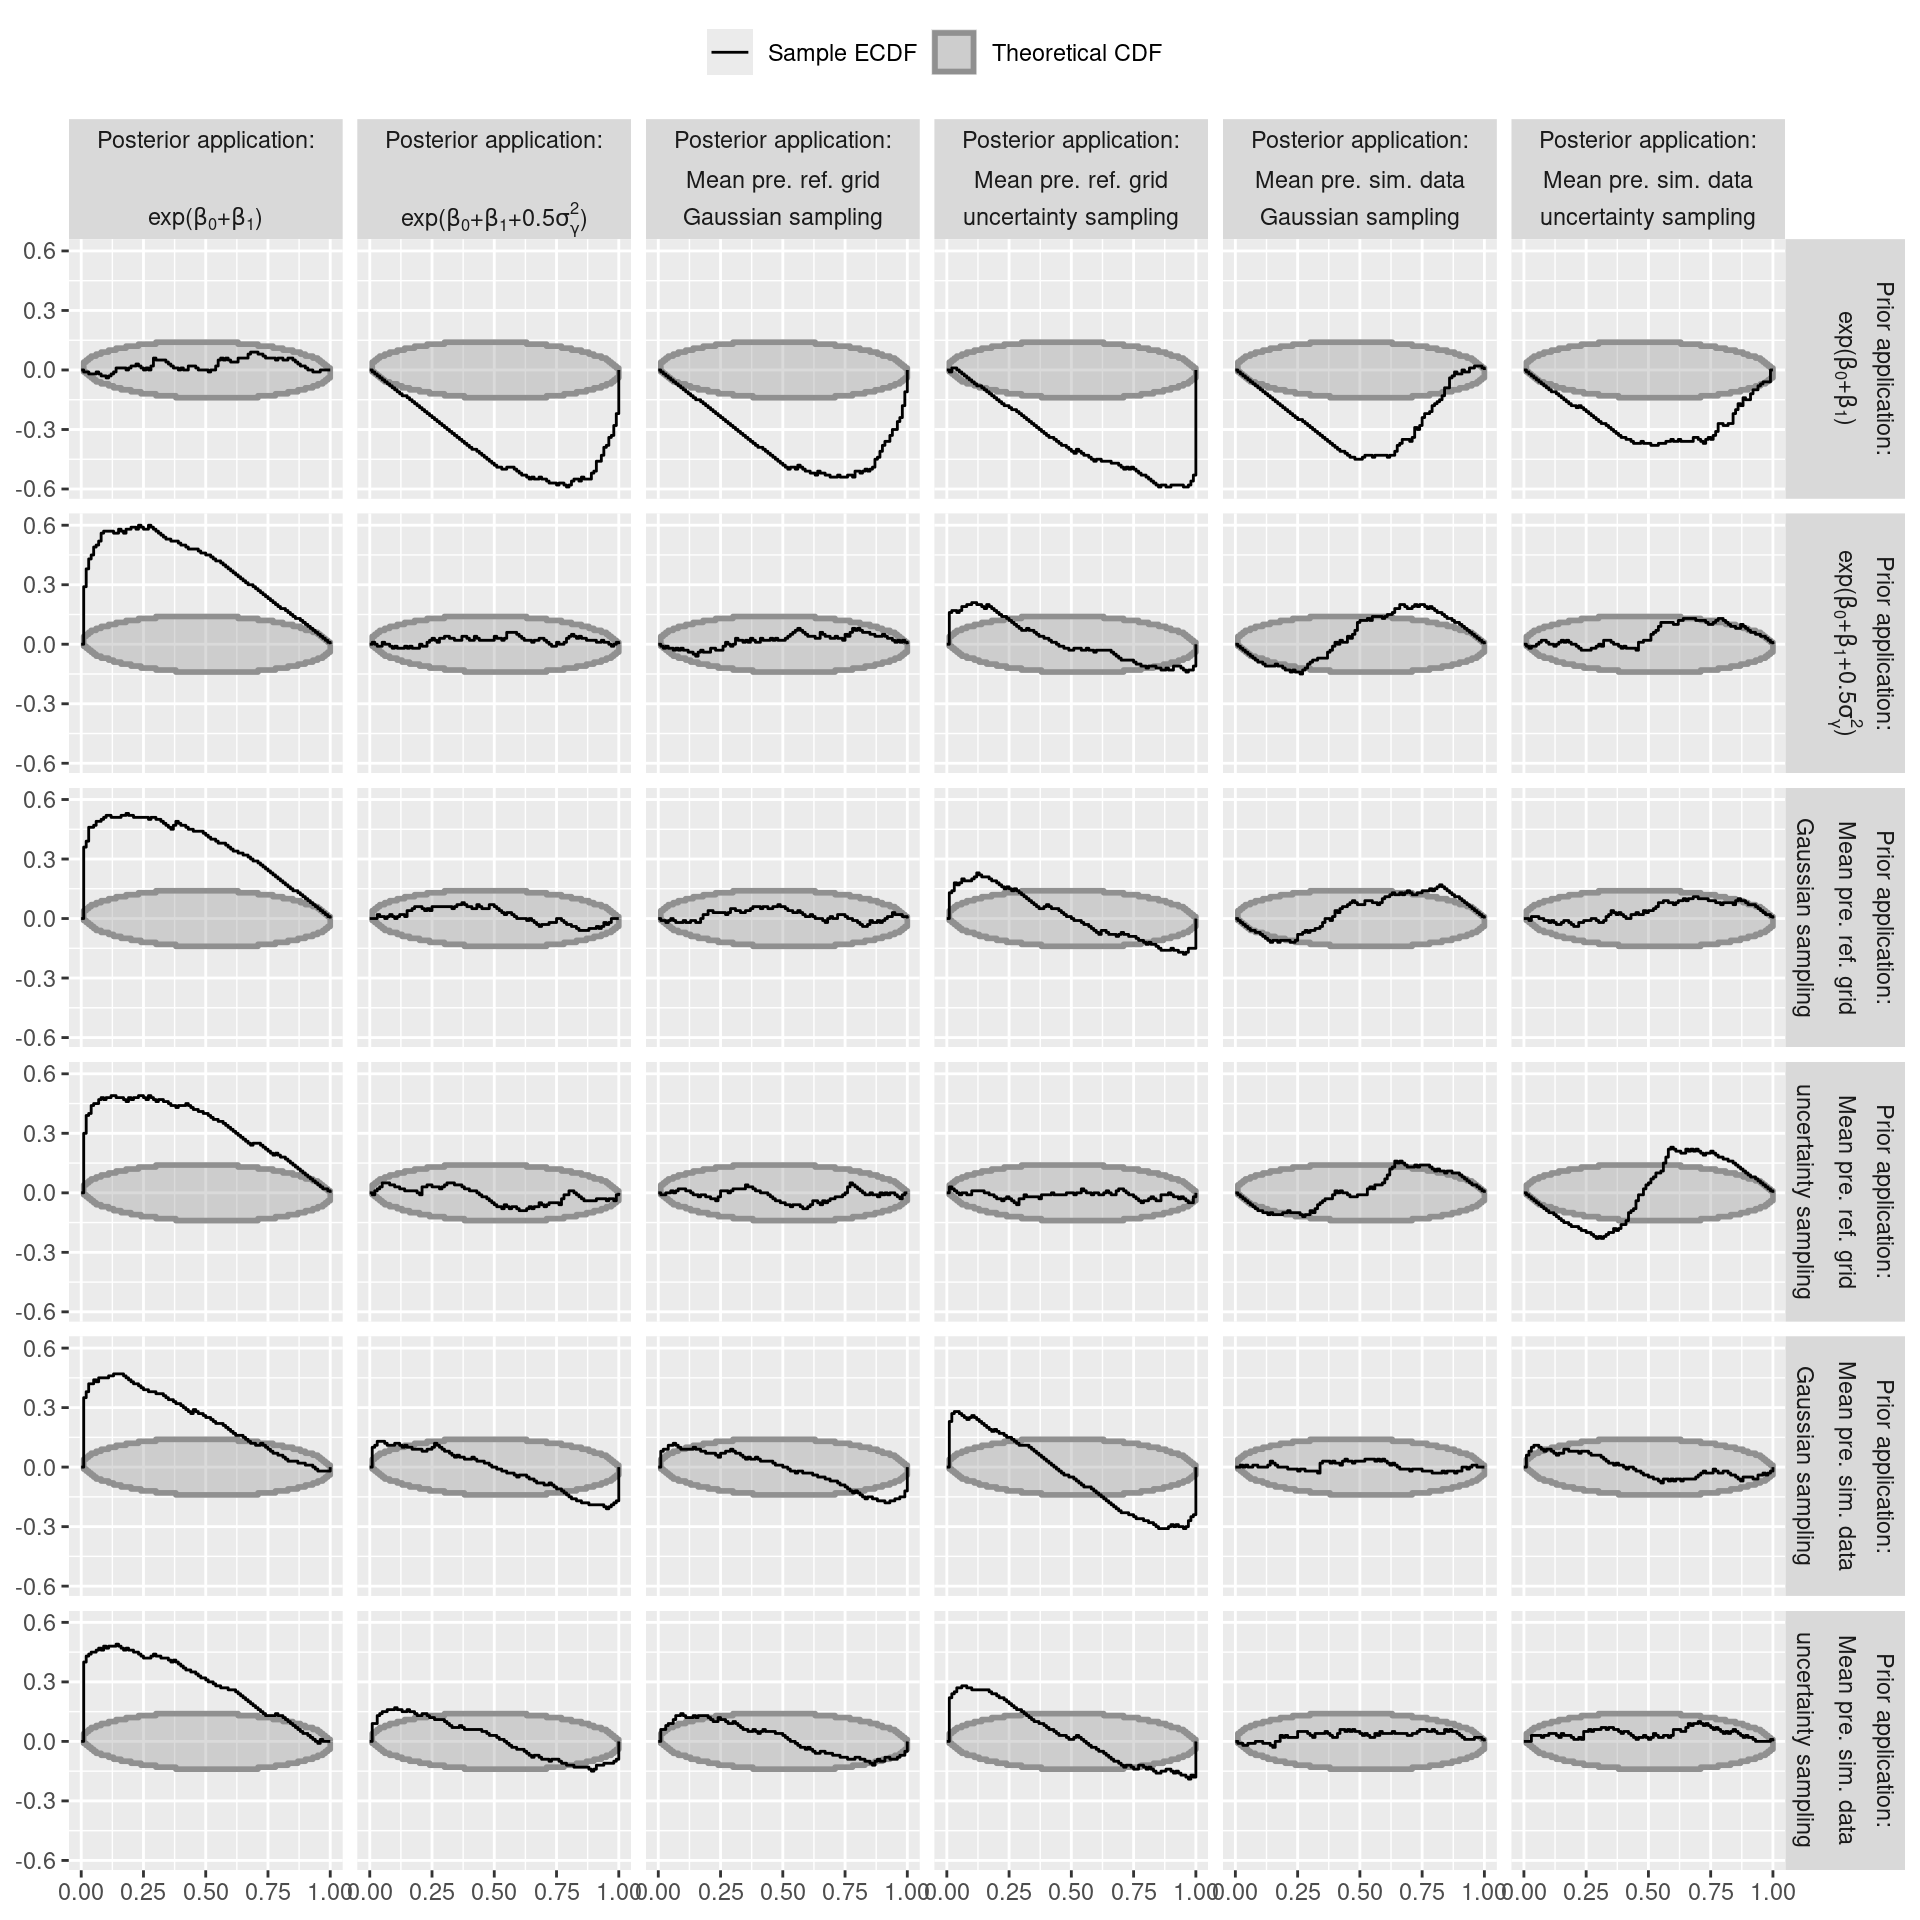

In [ ]:
tmp <- results_holdout_ppc
tmp$variable <- paste0("Mean of prediction on ", 
                       tmp$posterior_predict_population, " with\n", 
                       tmp$brms_sample_new_levels, " sampling for gamma.\n", 
                       "Prior application: ", tmp$use_prior)
tmp$variable <- gsub(x = tmp$variable, pattern = "gaussian", 
                     replacement = "Gaussian", fixed = T)
tmp$rank <- tmp$value * 1000
tmp$max_rank <- 1000
tmp$sim_id <- rep(1:100, 6 * 6)
tmp <- dat_ecdf_diff(x = tmp)
tmp$ecdf_df$x1 <- sapply(X = strsplit(x = tmp$ecdf_df$variable, split = '\n', 
                                      fixed = T), FUN = function(x){x[1]})
tmp$ecdf_df$x2 <- sapply(X = strsplit(x = tmp$ecdf_df$variable, split = '\n', 
                                      fixed = T), FUN = function(x){x[2]})
tmp$ecdf_df$x3 <- sapply(X = strsplit(x = tmp$ecdf_df$variable, split = '\n', 
                                      fixed = T), FUN = function(x){x[3]})
tmp$ecdf_df$x3 <- gsub(x = tmp$ecdf_df$x3, pattern = "Prior application: ", 
                       replacement = "", fixed = T)
tmp$ecdf_df$x3f <- as.factor(tmp$ecdf_df$x3)
tmp$ecdf_df$x4f <- as.factor(tmp$ecdf_df$x3)
levels(tmp$ecdf_df$x3f) <- c(expression("exp(" * beta[0] * "+" * beta[1] * ")"),
                             expression("exp(" * beta[0] * "+" * beta[1] * 
                                                     "+0.5" * sigma[gamma]^2 * ")"),
                             expression(paste("Mean pre. ref. grid")), 
                             expression(paste("Mean pre. ref. grid")), 
                             expression(paste("Mean pre. sim. data")), 
                             expression(paste("Mean pre. sim. data")), 
                             expression(paste("Mean pre. ref. grid")), 
                             expression(paste("Mean pre. ref. grid")), 
                             expression(paste("Mean pre. sim. data")), 
                             expression(paste("Mean pre. sim. data"))) 
levels(tmp$ecdf_df$x4f) <- c("",
                             "",
                             "Gaussian sampling", 
                             "uncertainty sampling",
                             "Gaussian sampling", 
                             "uncertainty sampling",
                             "Gaussian sampling", 
                             "uncertainty sampling",
                             "Gaussian sampling", 
                             "uncertainty sampling")
tmp$ecdf_df$x1a <- "Posterior application:"
tmp$ecdf_df$x3a <- "Prior application:"
tmp$ecdf_df$x1[tmp$ecdf_df$x1 == "Mean of prediction on none with"] <- " "
tmp$ecdf_df$x1f <- as.factor(tmp$ecdf_df$x1)
levels(tmp$ecdf_df$x1f) <- c(" ",  
                             "Mean pre. ref. grid", 
                             "Mean pre. sim. data")
tmp$ecdf_df$x2[tmp$ecdf_df$x2 == "none [exp(b0+b1)] sampling for gamma."] <- 
                                                                         "exp(b0+b1)"
tmp$ecdf_df$x2[tmp$ecdf_df$x2 == 
                         "none [exp(b0+b1+.5*sigma_gamma^2)] sampling for gamma."] <- 
                                                        "exp(b0+b1+.5*sigma_gamma^2)"
tmp$ecdf_df$x2f <- as.factor(tmp$ecdf_df$x2)
levels(tmp$ecdf_df$x2f) <- c(expression("exp(" * beta[0] * "+" * beta[1] * ")"),
                             expression("exp(" * beta[0] * "+" * beta[1] * 
                                                      "+0.5" * sigma[gamma]^2 * ")"),
                             expression(paste("Gaussian sampling")), 
                             expression(paste("uncertainty sampling"))) 
col_color <- col_fill <- 
                    c(colorspace::sequential_hcl(n = 20, pal = "Grays")[10], "black")
names(col_color) <- names(col_fill) <- 
    c("theoretical CDF", "sample ECDF")
l <- c('theoretical CDF' = expression("Theoretical CDF"), 
       'sample ECDF' = expression("Sample ECDF"))
ggplot(tmp$ecdf_df, aes(color = type, fill = type)) + 
  geom_ribbon(data = tmp$limits_df_trans, 
              aes(x = x, ymax = ymax, ymin = ymin), alpha = .33, 
              linewidth = 1) + 
  geom_step(aes(x = z, y = z_diff, group = variable)) + 
  scale_color_manual(name = "", values = col_color, labels = l) + 
  scale_fill_manual(name = "", values = col_fill, labels = l) + 
  scale_alpha_identity() + 
  xlab(NULL) + 
  ylab(NULL) + 
  facet_grid(cols = vars(x1a, x1f, x2f), 
             rows = vars(x3a, x3f, x4f), 
             labeller = labeller(x2f = label_parsed, 
                                 x3f = label_parsed)) +
  theme(strip.text = element_text(margin = margin(b = 0, t = 0))) +
  theme(legend.position = "top")

In [ ]:
pdf(file = "20241217_results_marginal_expectation_log_link_linear_mixed_model.pdf",
    height = 10, width = 10)
ggplot(tmp$ecdf_df, aes(color = type, fill = type)) + 
  geom_ribbon(data = tmp$limits_df_trans, 
              aes(x = x, ymax = ymax, ymin = ymin), alpha = .33, 
              linewidth = 1) + 
  geom_step(aes(x = z, y = z_diff, group = variable)) + 
  scale_color_manual(name = "", values = col_color, labels = l) + 
  scale_fill_manual(name = "", values = col_fill, labels = l) + 
  scale_alpha_identity() + 
  xlab(NULL) + 
  ylab(NULL) + 
  facet_grid(cols = vars(x1a, x1f, x2f), 
             rows = vars(x3a, x3f, x4f), 
             labeller = labeller(x2f = label_parsed, 
                                 x3f = label_parsed)) +
  theme(strip.text = element_text(margin = margin(b = 0, t = 0))) +
  theme(legend.position = "top")
invisible(dev.off())
# sort(unique(tmp$use_prior))
# 
# levels(tmp$use_prior) <- c(expression("100 µg " * .L^"-1" * ""))
# 
# plot_ecdf_diff_green(x = tmp) + 
#   theme(legend.position = "top") +
#   facet_grid(posterior_predict_population + brms_sample_new_levels ~ use_prior_f, 
#              labeller = label_parsed)
# 
# pdf("20241101_results_marginal_expectation_log_link_linear_mixed_model.pdf", 
#     height = 10, width = 13)
# plot_ecdf_diff_green(x = tmp) + 
#   theme(legend.position = "top")
# dev.off()

# ggplot(data = results_holdout_ppc, aes(x = value, fill = method)) + 
#   geom_histogram(binwidth = .05, boundary = 0, alpha = .5, position = "identity") + 
#   facet_grid(cols = vars(stat), rows = vars(equation)) +
#   # scale_fill_bam(discrete = T, reverse = T) + 
#   colorspace::scale_fill_discrete_qualitative(pal = "Dark 2") + 
#   theme(legend.position = "top") + 
#   labs(x = "Posterior predictive p value", 
#        fill = "Method:", 
#        y = "Simulation replication frequency") + 
#   coord_cartesian(xlim = c(0, 1))